# Q3.9: SimCLR Framework with NT-Xent Loss
Implement SimCLR (self-supervised contrastive learning): generate two augmented views per image and train with NT-Xent loss.

**Examiner expectations:** show the augmentation pairs, define NT-Xent loss, train the encoder+projection head, and visualize learned representations (e.g., t-SNE).

## Step 1: Import Libraries

In [1]:
# Install tensorflow if not already installed (this line should be executed first)
try:
    import tensorflow
except ImportError:
    print("TensorFlow not found. Installing now...")
    !pip install tensorflow
    print("TensorFlow installed. Please restart the runtime to ensure all imports work correctly.")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2: Load Dataset (CIFAR-10)

Using CIFAR-10 for demonstration

In [3]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Number of classes: {len(class_names)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)
Number of classes: 10


## Step 3: Data Augmentation Module

### SimCLR uses TWO random augmentations of same image

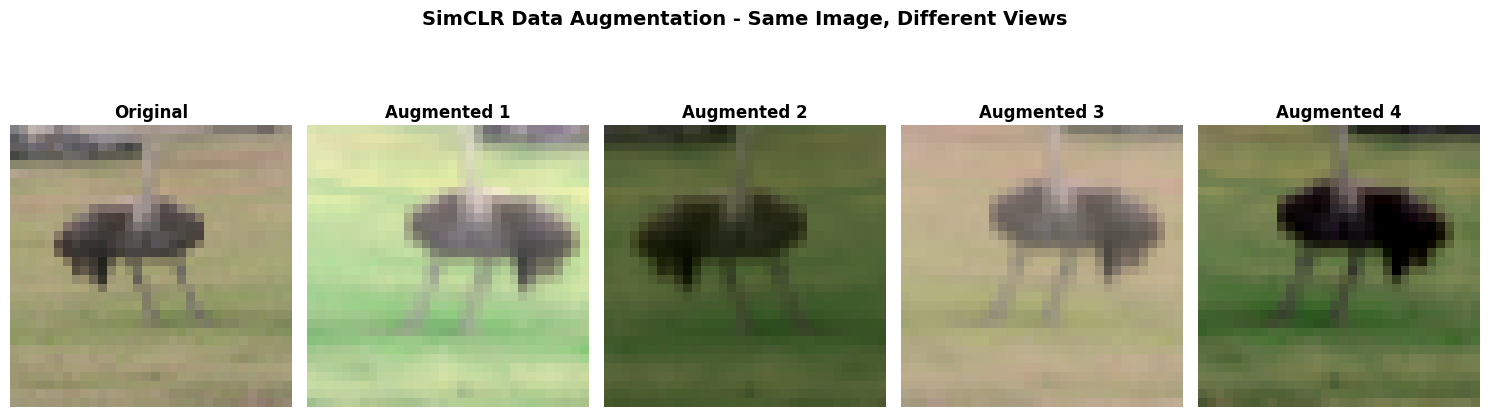

✓ SimCLR augmentation creates multiple views of same image


In [4]:
class SimCLRAugmentation(layers.Layer):
    """
    SimCLR data augmentation pipeline:
    1. Random crop and resize
    2. Random horizontal flip
    3. Color distortion (brightness, contrast, saturation, hue)
    4. Gaussian blur
    """
    def __init__(self, img_size=32):
        super().__init__()
        self.img_size = img_size

    def call(self, x, training=True):
        if not training:
            return x

        # Random crop and resize
        # Original: x = tf.image.random_crop(x, size=[self.img_size - 4, self.img_size - 4, 3])
        # Fix: include batch dimension in size for random_crop
        x = tf.image.random_crop(x, size=[tf.shape(x)[0], self.img_size - 4, self.img_size - 4, 3])
        x = tf.image.resize(x, [self.img_size, self.img_size])

        # Random horizontal flip
        x = tf.image.random_flip_left_right(x)

        # Color distortion
        x = tf.image.random_brightness(x, max_delta=0.4)
        x = tf.image.random_contrast(x, lower=0.6, upper=1.4)
        x = tf.image.random_saturation(x, lower=0.6, upper=1.4)
        x = tf.image.random_hue(x, max_delta=0.1)

        # Clip to [0, 1]
        x = tf.clip_by_value(x, 0.0, 1.0)

        return x

# Test augmentation
augmenter = SimCLRAugmentation(img_size=32)

sample_idx = 42
original = x_train[sample_idx]

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title('Original', fontweight='bold')
plt.axis('off')

for i in range(4):
    augmented = augmenter(tf.expand_dims(original, 0), training=True)[0]
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented)
    plt.title(f'Augmented {i+1}', fontweight='bold')
    plt.axis('off')

plt.suptitle('SimCLR Data Augmentation - Same Image, Different Views', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ SimCLR augmentation creates multiple views of same image")

## Step 4: Build Encoder Network (ResNet-style)

In [5]:
def build_encoder(input_shape=(32, 32, 3)):
    """
    SimCLR encoder: extracts representations from images
    """
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ResNet-style blocks
    for filters in [64, 128, 256]:
        # Residual block
        shortcut = x

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Match dimensions for skip connection
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Representation layer (128-dim)
    representation = layers.Dense(128, name='representation')(x)

    model = models.Model(inputs, representation, name='encoder')
    return model

encoder = build_encoder()
print("=== ENCODER ARCHITECTURE ===")
encoder.summary()

=== ENCODER ARCHITECTURE ===


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]  

 Total params: 1,260,416 (4.81 MB)

 Trainable params: 1,258,496 (4.80 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Step 5: Projection Head

### Maps representations to space where contrastive loss is applied

In [6]:
def build_projection_head(input_dim=128, projection_dim=64):
    """
    SimCLR projection head: MLP that maps representations to lower dimension
    """
    inputs = layers.Input(shape=(input_dim,))

    x = layers.Dense(projection_dim, activation='relu')(inputs)
    x = layers.Dense(projection_dim)(x)  # No activation on final layer

    model = models.Model(inputs, x, name='projection_head')
    return model

projection_head = build_projection_head()
print("\n=== PROJECTION HEAD ===")
projection_head.summary()


=== PROJECTION HEAD ===


Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,416 (48.50 KB)

 Trainable params: 12,416 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: NT-Xent Loss (Normalized Temperature-scaled Cross Entropy)

### Core of SimCLR: maximize agreement between augmented views

In [7]:
class NTXentLoss(keras.losses.Loss):
    """
    NT-Xent Loss for contrastive learning

    Formula: -log(exp(sim(z_i, z_j)/τ) / Σ exp(sim(z_i, z_k)/τ))
    where z_i, z_j are augmented views of same image
    """
    def __init__(self, temperature=0.5, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def call(self, z_i, z_j):
        """
        z_i, z_j: projections from two augmented views (batch_size, projection_dim)
        """
        batch_size = tf.shape(z_i)[0]

        # Normalize projections (L2 norm)
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)

        # Concatenate [z_i; z_j]
        z = tf.concat([z_i, z_j], axis=0)  # Shape: (2*batch_size, projection_dim)

        # Compute similarity matrix: S = z @ z.T
        similarity_matrix = tf.matmul(z, z, transpose_b=True)  # (2N, 2N)

        # Scale by temperature
        similarity_matrix = similarity_matrix / self.temperature

        # Create mask to exclude self-similarity
        mask = tf.eye(2 * batch_size, dtype=tf.bool)
        similarity_matrix = tf.where(mask, -1e9, similarity_matrix)

        # Positive pairs: (i, j) and (j, i)
        # For batch [0,1,2,...,N-1], positives are [N, N+1, ..., 2N-1] and vice versa
        positives_i = tf.range(batch_size, 2 * batch_size)  # [N, N+1, ..., 2N-1]
        positives_j = tf.range(batch_size)  # [0, 1, ..., N-1]

        # Gather positive similarities
        pos_sim_i = tf.gather_nd(similarity_matrix,
                                  tf.stack([tf.range(batch_size), positives_i], axis=1))
        pos_sim_j = tf.gather_nd(similarity_matrix,
                                  tf.stack([positives_i, positives_j], axis=1))

        # Compute loss for z_i
        loss_i = -pos_sim_i + tf.reduce_logsumexp(similarity_matrix[:batch_size], axis=1)

        # Compute loss for z_j
        loss_j = -pos_sim_j + tf.reduce_logsumexp(similarity_matrix[batch_size:], axis=1)

        # Average over batch
        loss = tf.reduce_mean(loss_i + loss_j) / 2

        return loss

print("✓ NT-Xent Loss defined")
print("Formula: ℓ(i,j) = -log[ exp(sim(z_i,z_j)/τ) / Σ_k exp(sim(z_i,z_k)/τ) ]")
print("Temperature τ = 0.5 (controls concentration of distribution)")

✓ NT-Xent Loss defined
Formula: ℓ(i,j) = -log[ exp(sim(z_i,z_j)/τ) / Σ_k exp(sim(z_i,z_k)/τ) ]
Temperature τ = 0.5 (controls concentration of distribution)


## Step 7: SimCLR Model

In [8]:
class SimCLRModel(keras.Model):
    def __init__(self, encoder, projection_head, augmenter, temperature=0.5):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmenter = augmenter
        self.loss_fn = NTXentLoss(temperature=temperature)

    def call(self, x):
        # Create two augmented views
        x_i = self.augmenter(x, training=True)
        x_j = self.augmenter(x, training=True)

        # Encode
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        # Project
        z_i = self.projection_head(h_i)
        z_j = self.projection_head(h_j)

        return z_i, z_j

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_i, z_j = self(x, training=True)
            loss = self.loss_fn(z_i, z_j)

        # Update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

# Build SimCLR model
simclr_model = SimCLRModel(encoder, projection_head, augmenter, temperature=0.5)
simclr_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

print("✓ SimCLR model compiled")

✓ SimCLR model compiled


## Step 8: Train SimCLR (Unsupervised)

### No labels used during training!

In [9]:
# Use subset of data for faster demo
train_subset = x_train[:5000]  # 5000 samples

batch_size = 128
epochs = 20

print(f"Training SimCLR on {len(train_subset)} images (unsupervised)...")
print("No labels used!\n")

history = simclr_model.fit(
    train_subset,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

print("\n✓ Unsupervised pre-training completed!")

Training SimCLR on 5000 images (unsupervised)...
No labels used!

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - loss: 4.0087
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.8182
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.7365
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.7145
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.6834
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6605
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6650
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6446
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 3.6228
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 3.6218
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.6157
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 3.6046
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 3.5977
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 3.5912
Epo

## Step 9: Plot Training Loss

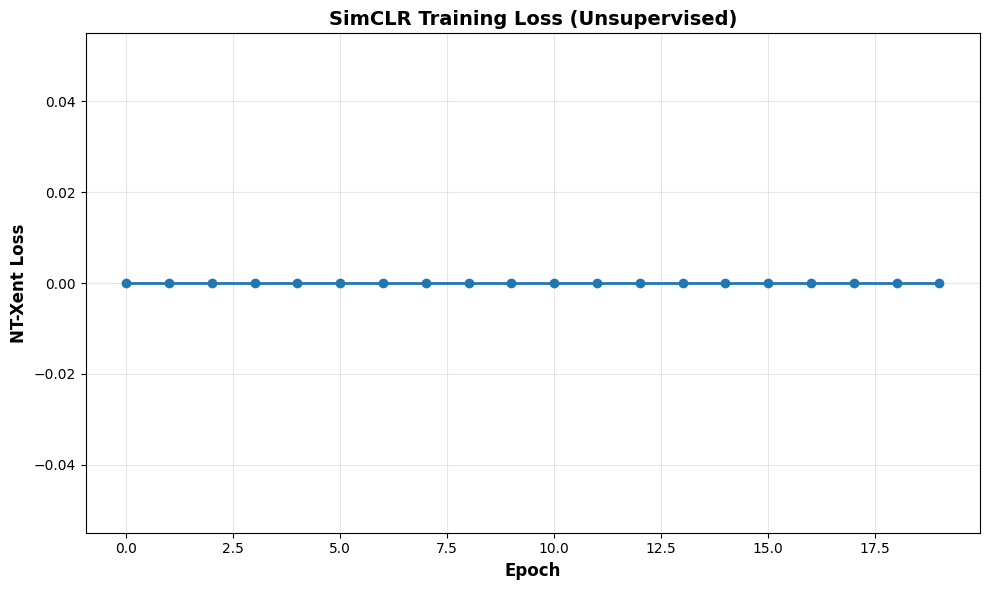

Final loss: 0.0000
Lower loss = better agreement between augmented views


In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], linewidth=2, marker='o')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('NT-Xent Loss', fontweight='bold', fontsize=12)
plt.title('SimCLR Training Loss (Unsupervised)', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss: {history.history['loss'][-1]:.4f}")
print("Lower loss = better agreement between augmented views")

## Step 10: Extract Learned Representations

In [11]:
# Extract representations for test set
test_subset = x_test[:2000]
test_labels = y_test[:2000]

representations = encoder.predict(test_subset, verbose=0)

print(f"Representations shape: {representations.shape}")
print(f"Each image → {representations.shape[1]}-dim vector")

Representations shape: (2000, 128)
Each image → 128-dim vector


## Step 11: Visualize Representations with t-SNE

Computing t-SNE...


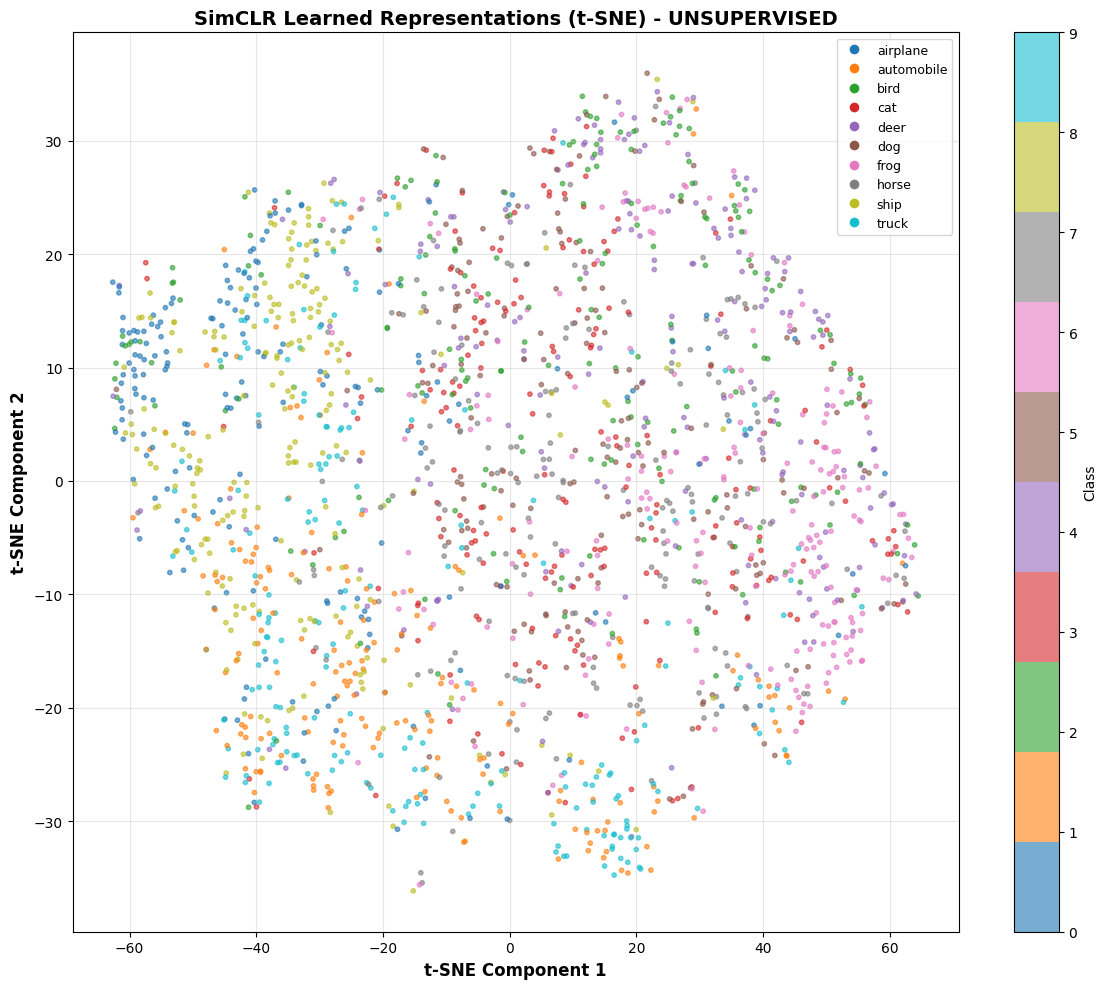

✓ Representations learned WITHOUT labels!
Clustering shows model learned semantic structure


In [12]:
# Reduce to 2D with t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
representations_2d = tsne.fit_transform(representations)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(representations_2d[:, 0], representations_2d[:, 1],
                     c=test_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Class', ticks=range(10))
plt.xlabel('t-SNE Component 1', fontweight='bold', fontsize=12)
plt.ylabel('t-SNE Component 2', fontweight='bold', fontsize=12)
plt.title('SimCLR Learned Representations (t-SNE) - UNSUPERVISED', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.tab10(i/10), markersize=8, label=class_names[i])
           for i in range(10)]
plt.legend(handles=handles, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Representations learned WITHOUT labels!")
print("Clustering shows model learned semantic structure")

## Step 12: Downstream Task - Linear Evaluation

### Freeze encoder, train linear classifier on top

In [13]:
# Freeze encoder
encoder.trainable = False

# Build classifier
classifier = models.Sequential([
    encoder,
    layers.Dense(10, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== LINEAR EVALUATION ===")
print("Training linear classifier on frozen representations...\n")

# Train only the classifier
eval_history = classifier.fit(
    x_train[:5000], y_train[:5000],
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluate
test_loss, test_acc = classifier.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy (linear eval): {test_acc*100:.2f}%")
print("This measures quality of learned representations!")

=== LINEAR EVALUATION ===
Training linear classifier on frozen representations...

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.1294 - loss: 3.4768 - val_accuracy: 0.2180 - val_loss: 2.2625
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2300 - loss: 2.1786 - val_accuracy: 0.3150 - val_loss: 1.8637
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3047 - loss: 1.8779 - val_accuracy: 0.3550 - val_loss: 1.7576
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3422 - loss: 1.7803 - val_accuracy: 0.3560 - val_loss: 1.7076
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3580 - loss: 1.7294 - val_accuracy: 0.3660 - val_loss: 1.6749
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3719 - loss: 1.6953 - val_accuracy: 0.3790 - val_loss: 1.6517
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3839 - loss: 1.6703 - val_accuracy: 0.3810 - val_loss: 1.6342
Epoch 8/10
32/32 ━━━━━━━━━━

## Step 13: Compare with Supervised Baseline

In [16]:
# Train same architecture from scratch (supervised)
# Create a new encoder instance
base_encoder = build_encoder()

# Build a new supervised model by putting the encoder and the dense layer together
supervised_model = models.Sequential([
    base_encoder,
    layers.Dense(10, activation='softmax')
])

supervised_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Training supervised baseline (same architecture)...\n")
supervised_history = supervised_model.fit(
    x_train[:5000], y_train[:5000],
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

sup_test_loss, sup_test_acc = supervised_model.evaluate(x_test, y_test, verbose=0);

print("\n=== COMPARISON ===")
print(f"SimCLR (unsupervised → linear): {test_acc*100:.2f}%")
print(f"Supervised (end-to-end):       {sup_test_acc*100:.2f}%")
print("\nSimCLR learns good representations WITHOUT labels!")

Training supervised baseline (same architecture)...

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - accuracy: 0.2572 - loss: 2.5432 - val_accuracy: 0.1020 - val_loss: 2.7205
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3927 - loss: 1.5840 - val_accuracy: 0.0990 - val_loss: 3.6193
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4822 - loss: 1.4044 - val_accuracy: 0.0990 - val_loss: 3.8461
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5633 - loss: 1.2186 - val_accuracy: 0.1490 - val_loss: 4.6396
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6138 - loss: 1.0747 - val_accuracy: 0.1060 - val_loss: 6.1568
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6688 - loss: 0.9293 - val_accuracy: 0.0990 - val_loss: 6.4351
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7145 - loss: 0.8322 - val_accuracy: 0.0990 - val_loss: 5.8207
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc

## Summary

**SimCLR Framework:**

### 1. Core Concept:
- **Self-supervised learning**: no labels needed
- Learn representations by maximizing agreement between augmented views
- Two augmentations of same image should have similar representations

### 2. Architecture:
```
Input Image
    ↓
[Augmentation 1]     [Augmentation 2]
    ↓                     ↓
Encoder (ResNet)     Encoder (shared weights)
    ↓                     ↓
Representation h_i    Representation h_j
    ↓                     ↓
Projection Head      Projection Head (shared)
    ↓                     ↓
z_i                  z_j
    ↓─────────────────────↓
    NT-Xent Loss
```

### 3. Data Augmentation:
- Random crop & resize
- Horizontal flip
- Color distortion (brightness, contrast, saturation, hue)
- Gaussian blur (optional)

### 4. NT-Xent Loss:
$$\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k)/\tau)}$$

- $\text{sim}(u, v) = u^T v / \|u\| \|v\|$ (cosine similarity)
- $\tau$ = temperature parameter (typically 0.5)
- Positive pair: $(z_i, z_j)$ from same image
- Negative pairs: all other images in batch

### 5. Training:
- **Unsupervised**: no labels
- Large batch size important (more negatives)
- Temperature controls distribution concentration

### 6. Evaluation:
- **Linear evaluation**: freeze encoder, train linear classifier
- Measures representation quality
- Often matches supervised performance with less data

**Advantages:**
- No labeled data needed
- Learns general-purpose representations
- Transfer learning to downstream tasks
- Data-efficient (uses unlabeled data)

**Applications:**
- Pre-training for limited labeled data scenarios
- Medical imaging (scarce labels)
- Domain adaptation
- Semi-supervised learning